# **Simple QNN**

### Resume: 
This is a super simple example using a QNN

## References

- https://arxiv.org/pdf/1802.06002.pdf

---

## Installation
We will install TF 2.5.1 (version required by TFQ) and TF-Quantum. 
> Check https://www.tensorflow.org/quantum/install for updates.



In [ ]:
%%capture
!pip install -q tensorflow==2.5.1
!pip install -q -U tensorflow-quantum
!pip install -q -U tfq-nightly
import importlib, pkg_resources
importlib.reload(pkg_resources)

In [ ]:
# !pip show tensorflow
# !pip show tensorflow-quantum
# !pip show tfq-nightly

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np
import collections
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

---
## Data Set

Lets create custom data set:

```
    X   |   Y
--------+-------
  0010  |   0
  1010  |   0
  0110  |   1
  1110  |   1
  1101  |   0
```

### Create the data

In [ ]:
def create_dataset():
  # The value of x will be obtained:
  #   x = b3* 2^3 + b2 * 2^2 + b1 * 2^1 + b0 2^0
  # where the b are related to a binary value of each qubit.
  x = [4,5,6,7,11]
  y = [False,False,True,True,False]
  TOTAL_VALUES = len(x)
  
  x_data = np.zeros((TOTAL_VALUES,4,1))
  y_data = np.zeros((TOTAL_VALUES,),dtype = bool)

  # Lets check we created the right shape...
  print("shape(x_data) = ", x_data.shape)
  print("shape(y_data) = ", y_data.shape)
  
  # Lets create the dataset
  print()
  print("X  b0 b1 b2 b3  Y")
  for value in range(TOTAL_VALUES):
    for b in range(4):
      # Lets check if the bit is 1
      if( (x[value] >> b)  % 2 ):
        x_data[value,b,0] = 1.0
    y_data[value] = y[value]
    print(value, x_data[value,:,0],y_data[value])
  return x_data, y_data

In [ ]:
x_data, y_data = create_dataset()

shape(x_data) =  (5, 4, 1)
shape(y_data) =  (5,)

X  b0 b1 b2 b3  Y
0 [0. 0. 1. 0.] False
1 [1. 0. 1. 0.] False
2 [0. 1. 1. 0.] True
3 [1. 1. 1. 0.] True
4 [1. 1. 0. 1.] False


### Preparing the Data

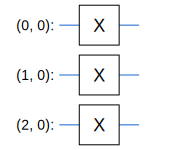

In [ ]:
# We start with a |0000> and we want the output to be a certain value.
# To do so, we will apply an X to the right qubit.
def inputs_to_circuit(data):
    # Encode truncated classical image into quantum datapoint.
    qubits = cirq.GridQubit.rect(4, 1)
    circuit = cirq.Circuit()
    for i in range(4):
        if data[i]:
            circuit.append(cirq.X(qubits[i]))
    return circuit

# Lets create a circuit for each element
x_data_circ = [inputs_to_circuit(x) for x in x_data]

# Lets show an output that we now it has 1s and 0s.
SVGCircuit(x_data_circ[3])

In [ ]:
x_data_tfcirc = tfq.convert_to_tensor(x_data_circ)

In [ ]:
# Lets convert the y_data to values between 1 (True) and -1 (False)
y_hinge = 2.0*y_data-1.0
print(y_hinge[:])

[-1. -1.  1.  1. -1.]


## Circuit

### Create the circuit

In [ ]:
# Lets create a class that contains the qubits and layers.
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

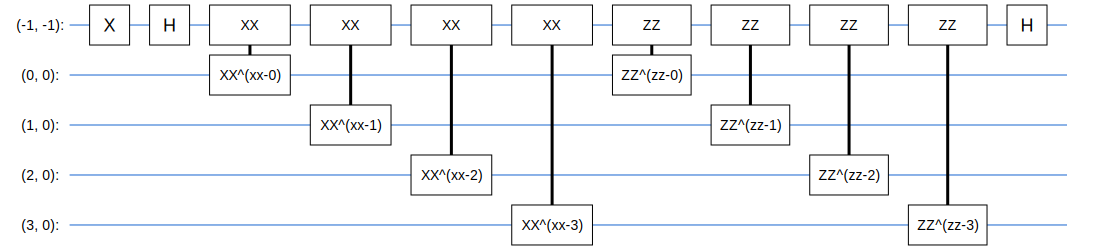

In [ ]:
#    --------               -------------
#  --|  XX  |---          --|           |--
#    --------               |           |
#        |            =     |   Rxx(t)  |
#    --------               |           |
#  --|XX^(xx)|---         --|           |--
#    --------               -------------
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4,1)
    readout = cirq.GridQubit(-1,-1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    cirq_builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout = readout)

    # Then add layers (experiment by adding more).
    cirq_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
    cirq_builder.add_layer(circuit, gate = cirq.ZZ, prefix='zz')

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

model_circuit, model_readout = create_quantum_model()

SVGCircuit(model_circuit)

### The model circuit

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

## Compile  and Fit

### Compile

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)
    return tf.reduce_mean(result)

In [ ]:
optimizer=tf.keras.optimizers.Adam()
loss=tf.keras.losses.Hinge()
model.compile(
    loss      = loss,
    optimizer = optimizer,
    metrics   = [hinge_accuracy])

In [ ]:
# 32 params as we have a RXX and a RZZ for each qubit (16).
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_14 (PQC)                 (None, 1)                 8         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
None


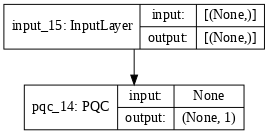

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

### Finally Fit

In [ ]:
EPOCHS = 500
BATCH_SIZE = 5
NUM_EXAMPLES = len(x_data)

In [ ]:
qnn_history = model.fit(
      x_data_tfcirc, y_hinge,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)
for n in range(len(x_data)):
  qnn_results = model.predict(tfq.convert_to_tensor([x_data_circ[n]]))
  print(n, qnn_results, y_data_hinge_sub[n])

## Next Level
- Adding an extra element to the data set (0011 -> True) and using callback to stop the fit.
